In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
labels_per_class = 'full' # full

### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

In [8]:
num_classes=10

In [9]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [10]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

### Network architecture

In [11]:
dims = (32,32,3)
n_components= 1024


In [12]:
from tensorflow.keras import datasets, layers, models
from tensorflow_addons.layers import WeightNormalization

def conv_block(filts, name, kernel_size = (3, 3), padding = "same", **kwargs):
    return WeightNormalization(
        layers.Conv2D(
            filts, kernel_size, activation=None, padding=padding, **kwargs
        ),
        name="conv"+name,
    )
#CNN13
#See: 
#https://github.com/vikasverma1077/ICT/blob/master/networks/lenet.py
#https://github.com/brain-research/realistic-ssl-evaluation

In [13]:
lr_alpha = 0.1
dropout_rate = 0.5
num_classes = 10
encoder = models.Sequential()
encoder.add(tf.keras.Input(shape=dims))
### conv1a
name = '1a'
encoder.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1b
name = '1b'
encoder.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1c
name = '1c'
encoder.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
encoder.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp1"))
# dropout
encoder.add(layers.Dropout(dropout_rate, name="drop1"))

### conv2a
name = '2a'
encoder.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha))

### conv2b
name = '2b'
encoder.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv2c
name = '2c'
encoder.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
encoder.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp2"))
# dropout
encoder.add(layers.Dropout(dropout_rate, name="drop2"))

### conv3a
name = '3a'
encoder.add(conv_block(name = name, filts = 512, kernel_size = (3,3), padding="valid"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3b
name = '3b'
encoder.add(conv_block(name = name, filts = 256, kernel_size = (1,1), padding="valid"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3c
name = '3c'
encoder.add(conv_block(name = name, filts = 128, kernel_size = (1,1), padding="valid"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
encoder.add(layers.AveragePooling2D(pool_size=(6, 6), strides=2, padding='valid'))
encoder.add(layers.Flatten())
encoder.add(layers.Dense(256, activation=None, name='z'))

In [14]:
classifier = models.Sequential()
classifier.add(tf.keras.Input(shape=(256)))
classifier.add(WeightNormalization(layers.Dense(256, activation=None)))
classifier.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc1'))
classifier.add(WeightNormalization(layers.Dense(256, activation=None)))
classifier.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc2'))
classifier.add(WeightNormalization(layers.Dense(num_classes, activation=None), name='y_'))

In [15]:
embedder = models.Sequential()
embedder.add(tf.keras.Input(shape=(256)))
embedder.add(WeightNormalization(layers.Dense(256, activation=None)))
embedder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc1'))
embedder.add(WeightNormalization(layers.Dense(256, activation=None)))
embedder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc2'))
embedder.add(WeightNormalization(layers.Dense(n_components, activation=None), name='z_'))

### Test model with just UMAP

In [16]:
from tfumap.semisupervised import find_a_b
from tfumap.umap import convert_distance_to_probability

In [17]:
min_dist = 0.0
_a, _b = find_a_b(min_dist)
_a, _b 

(<tf.Tensor: shape=(), dtype=float32, numpy=1.9328084>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.790495>)

##### build iterator

In [18]:
from tfumap.semisupervised import build_fuzzy_simplicial_set
from tfumap.umap import compute_cross_entropy, get_graph_elements

In [19]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    y=Y_masked,
    n_neighbors=n_neighbors,
)

In [20]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
#batch_size = np.min([n_vertices, 1000])
batch_size = 128
batch_size

128

In [21]:
max_sample_repeats_per_epoch = 25
# set the maximum number of times each edge should be repeated per epoch
epochs_per_sample = np.clip(
    (weight / np.max(weight)) * max_sample_repeats_per_epoch,
    1,
    max_sample_repeats_per_epoch,
).astype("int")

In [22]:
edges_to_exp, edges_from_exp = (
        np.repeat(head, epochs_per_sample.astype("int")),
       np.repeat(tail, epochs_per_sample.astype("int")),
)
shuffle_mask = np.random.permutation(range(len(edges_to_exp)))
edges_to_exp = edges_to_exp[shuffle_mask]
edges_from_exp = edges_from_exp[shuffle_mask]

In [23]:
negative_sample_rate = 5

In [24]:
def gather_X(edge_to, edge_from):
    return (tf.gather(X_train, edge_to), tf.gather(X_train, edge_from)), 0

In [25]:
edge_iter = tf.data.Dataset.from_tensor_slices((edges_to_exp, edges_from_exp))
edge_iter = edge_iter.shuffle(10000)
edge_iter = edge_iter.map(gather_X, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [26]:
labeled_dataset = tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled_one_hot)).shuffle(len(X_labeled)).repeat()
labeled_dataset

<RepeatDataset shapes: ((32, 32, 3), (10,)), types: (tf.float32, tf.float32)>

In [27]:
def rearrange_output(label_iter_out, edge_iter_out):
    X_lab, Y_lab = label_iter_out
    (X_to, X_from), edge_prob = edge_iter_out
    return (X_lab, X_to, X_from), {"classifier":Y_lab, "umap": edge_prob}

In [28]:
zipped_ds = tf.data.Dataset.zip((labeled_dataset, edge_iter))
zipped_ds = zipped_ds.map(rearrange_output, num_parallel_calls=tf.data.experimental.AUTOTUNE)
zipped_ds = zipped_ds.batch(batch_size, drop_remainder=True)
zipped_ds

<BatchDataset shapes: (((128, 32, 32, 3), (128, 32, 32, 3), (128, 32, 32, 3)), {classifier: (128, 10), umap: (128,)}), types: ((tf.float32, tf.float32, tf.float32), {classifier: tf.float32, umap: tf.int32})>

In [29]:
(X_lab, X_to, X_from), test  = next(iter(zipped_ds))
X_lab.shape, X_to.shape, X_from.shape

(TensorShape([128, 32, 32, 3]),
 TensorShape([128, 32, 32, 3]),
 TensorShape([128, 32, 32, 3]))

#### Build network

In [30]:
def umap_loss(batch_size, negative_sample_rate, _a, _b, repulsion_strength = 1.0):
    @tf.function
    def loss(placeholder_y, embed_to_from):
        # split out to/from
        embedding_to, embedding_from = tf.split(embed_to_from, num_or_size_splits=2, axis=1)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )
        
        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
            axis=0,
        )
                
        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=repulsion_strength,
        )
        return tf.reduce_mean(ce_loss)

    return loss

In [31]:
from tensorflow.keras.layers import Input

In [32]:
to_x = Input(shape=dims, name = "to_x")
from_x = Input(shape=dims, name = "from_x")
classifier_x = Input(shape=dims, name = "classifier_x")


embedding_to = embedder(encoder(to_x))
embedding_from = embedder(encoder(from_x))
embedding_to_from = tf.concat([embedding_to, embedding_from], axis = 1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name='umap')(embedding_to_from)

predictions = classifier(encoder(classifier_x))
predictions = tf.keras.layers.Lambda(lambda x: x, name='classifier')(predictions)

model = tf.keras.Model(
    inputs=[classifier_x, to_x, from_x],
    outputs={"classifier": predictions, "umap":embedding_to_from},
)

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        "classifier": tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True),
        "umap": umap_loss(batch_size, negative_sample_rate, _a, _b),
    },
    loss_weights = {
        "classifier": 1.0,
        "umap": 1.0,
    },
    metrics={"classifier":"accuracy"}

)

In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_classifier_loss', min_delta=0, patience=50, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [35]:
num_batches = np.floor(len(X_train)/batch_size).astype(int)
num_batches

312

In [36]:
history = model.fit(
    zipped_ds,
    epochs=100,
    validation_data=(
        (X_valid, tf.zeros_like(X_valid), tf.zeros_like(X_valid)),
        {"classifier": Y_valid_one_hot},
    ),
    callbacks = [early_stopping],
    max_queue_size = 100,
    steps_per_epoch = num_batches
)

Epoch 1/100
312/312 [==============================] - 49s 156ms/step - loss: 2.2149 - classifier_loss: 1.9002 - umap_loss: 0.3147 - classifier_accuracy: 0.4157 - val_loss: 1.7733 - val_classifier_loss: 1.7733 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.4880
Epoch 2/100
312/312 [==============================] - 46s 146ms/step - loss: 1.8193 - classifier_loss: 1.5690 - umap_loss: 0.2502 - classifier_accuracy: 0.6023 - val_loss: 1.6051 - val_classifier_loss: 1.6051 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.5901
Epoch 3/100
312/312 [==============================] - 46s 146ms/step - loss: 1.6826 - classifier_loss: 1.4398 - umap_loss: 0.2428 - classifier_accuracy: 0.6806 - val_loss: 1.5306 - val_classifier_loss: 1.5306 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.6315
Epoch 4/100
312/312 [==============================] - 45s 145ms/step - loss: 1.5930 - classifier_loss: 1.3552 - umap_loss: 0.2377 - classifier_accuracy: 0.7328 - val_loss: 1.4603 - va

312/312 [==============================] - 45s 145ms/step - loss: 1.1206 - classifier_loss: 0.9454 - umap_loss: 0.1752 - classifier_accuracy: 0.9610 - val_loss: 1.1150 - val_classifier_loss: 1.1150 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.8763
Epoch 32/100
312/312 [==============================] - 45s 145ms/step - loss: 1.1128 - classifier_loss: 0.9402 - umap_loss: 0.1726 - classifier_accuracy: 0.9631 - val_loss: 1.0879 - val_classifier_loss: 1.0879 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.8890
Epoch 33/100
312/312 [==============================] - 45s 145ms/step - loss: 1.1093 - classifier_loss: 0.9389 - umap_loss: 0.1705 - classifier_accuracy: 0.9648 - val_loss: 1.1357 - val_classifier_loss: 1.1357 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.8666
Epoch 34/100
312/312 [==============================] - 45s 145ms/step - loss: 1.1016 - classifier_loss: 0.9318 - umap_loss: 0.1698 - classifier_accuracy: 0.9677 - val_loss: 1.1114 - val_classif

312/312 [==============================] - 45s 145ms/step - loss: 1.0368 - classifier_loss: 0.8927 - umap_loss: 0.1441 - classifier_accuracy: 0.9876 - val_loss: 1.1008 - val_classifier_loss: 1.1008 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.8914
Epoch 62/100
312/312 [==============================] - 45s 145ms/step - loss: 1.0357 - classifier_loss: 0.8915 - umap_loss: 0.1442 - classifier_accuracy: 0.9881 - val_loss: 1.1026 - val_classifier_loss: 1.1026 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.8901
Epoch 63/100
312/312 [==============================] - 45s 145ms/step - loss: 1.0351 - classifier_loss: 0.8905 - umap_loss: 0.1446 - classifier_accuracy: 0.9886 - val_loss: 1.1094 - val_classifier_loss: 1.1094 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.8861
Epoch 64/100
312/312 [==============================] - 45s 145ms/step - loss: 1.0332 - classifier_loss: 0.8898 - umap_loss: 0.1434 - classifier_accuracy: 0.9888 - val_loss: 1.0978 - val_classif

312/312 [==============================] - 46s 147ms/step - loss: 1.0173 - classifier_loss: 0.8843 - umap_loss: 0.1330 - classifier_accuracy: 0.9915 - val_loss: 1.1052 - val_classifier_loss: 1.1052 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.8875
Epoch 92/100
312/312 [==============================] - 46s 147ms/step - loss: 1.0122 - classifier_loss: 0.8797 - umap_loss: 0.1325 - classifier_accuracy: 0.9939 - val_loss: 1.0839 - val_classifier_loss: 1.0839 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.9007
Epoch 93/100
312/312 [==============================] - 46s 147ms/step - loss: 1.0136 - classifier_loss: 0.8804 - umap_loss: 0.1332 - classifier_accuracy: 0.9938 - val_loss: 1.0948 - val_classifier_loss: 1.0948 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.8957
Epoch 94/100
 88/312 [=======>......................] - ETA: 28s - loss: 1.0205 - classifier_loss: 0.8856 - umap_loss: 0.1349 - classifier_accuracy: 0.9913

W0810 23:03:02.565945 140314247128896 data_adapter.py:1182] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 31200 batches). You may need to use the repeat() function when building your dataset.


 88/312 [=======>......................] - 17s 198ms/step - loss: 1.0205 - classifier_loss: 0.8856 - umap_loss: 0.1349 - classifier_accuracy: 0.9913 - val_loss: 1.0878 - val_classifier_loss: 1.0878 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.8990


In [37]:
pred_test = classifier.predict(encoder.predict(X_test))

In [38]:
np.mean(np.argmax(pred_test, axis = 1) == Y_test)

0.8956

In [39]:
z = embedder.predict(encoder.predict(X_train))

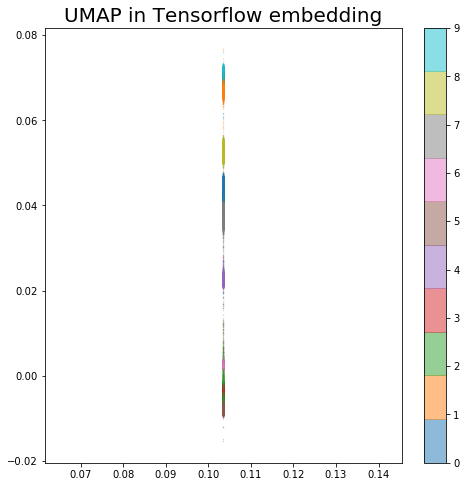

In [40]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

In [41]:
history.history.keys()

dict_keys(['loss', 'classifier_loss', 'umap_loss', 'classifier_accuracy', 'val_loss', 'val_classifier_loss', 'val_umap_loss', 'val_classifier_accuracy'])

Text(0.5, 1.0, 'classifier acc')

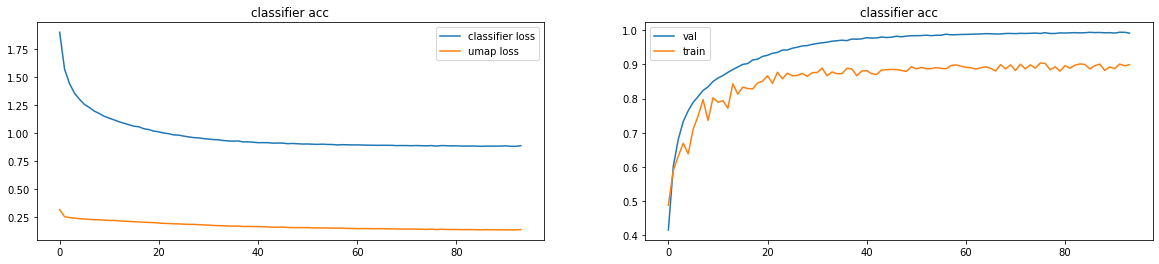

In [42]:
fig, axs = plt.subplots(ncols = 2, figsize=(20,4))

ax = axs[0]
ax.plot(history.history['classifier_loss'], label='classifier loss')
ax.plot(history.history['umap_loss'], label='umap loss')
ax.set_title("classifier acc")
ax.legend()
ax = axs[1]
ax.plot(history.history['classifier_accuracy'], label='val')
ax.plot(history.history['val_classifier_accuracy'], label='train')
ax.legend()
ax.set_title("classifier acc")

In [ ]:
### get last layer activation

In [ ]:
pred_model = tf.keras.models.Model(model.classifier.input,[model.classifier.get_layer(name="dense_1").get_output_at(0)])